In [2]:
import numpy as np
import numba as nb
import pandas as pd
import laspy
import numba
import glob
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix as distance_matrix

# load Amsterdam bomen to pandas df

In [64]:
def avg_boomhoogte(row):
    boomh_str = row["Boomhoogte"]
    avg = 0.0
    try:
        avg = (float(boomh_str.split(" ")[0]) + float(boomh_str.split(" ")[2]))/2
    except:
        return np.NaN
    return avg

bomen = []
for filename in glob.glob("BOMEN*.csv"):
    df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
    bomen.append(df)
bomen = pd.concat(bomen, axis=0, ignore_index=True)
bomen = bomen[bomen.Plantjaar < 2013].reset_index()
bomen['AVG_Boomhoogte'] = bomen.apply(lambda row: avg_boomhoogte(row), axis=1)
bomen

,index,OBJECTNUMMER,Soortnaam_NL,Boomnummer,Soortnaam_WTS,Boomtype,Boomhoogte,Plantjaar,Eigenaar,Beheerder,Categorie,SOORT_KORT,SDVIEW,RADIUS,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,Unnamed: 17,AVG_Boomhoogte
0,0,1,Amerikaanse linde,589672,Tilia americana,Boom niet vrij uitgroeiend,12 tot 18 m.,1948,Gemeente Amsterdam,Stadsdeel Zuid,Tilia,Tilia,K,5,POINT(4.90467 52.339815),POINT(52.339815 4.90467),4.904670,52.339815,NaN,15.0
1,1,2,Huntingdon-iep,589671,Ulmus hollandica `Vegeta`,Boom niet vrij uitgroeiend,6 tot 12 m.,1978,Gemeente Amsterdam,Stadsdeel Zuid,Ulmus,Ulmus,K,3,POINT(4.902692 52.340094),POINT(52.340094 4.902692),4.902692,52.340094,NaN,9.0
2,2,3,Gewone es (cultuurvariëteit),589670,Fraxinus excelsior `Westhof`s Glorie`,Boom niet vrij uitgroeiend,9 tot 12 m.,1990,Gemeente Amsterdam,Stadsdeel Zuid,Fraxinus,Fraxinus,K,3,POINT(4.855208 52.331986),POINT(52.331986 4.855208),4.855208,52.331986,NaN,10.5
3,3,4,Gele bergiep (cultuurvariëteit),589669,Ulmus glabra `Lutescens`,Boom niet vrij uitgroeiend,6 tot 12 m.,2002,Gemeente Amsterdam,Stadsdeel Zuid,Ulmus,Ulmus,K,3,POINT(4.90367 52.348838),POINT(52.348838 4.90367),4.903670,52.348838,NaN,9.0
4,4,5,Zomereik,589668,Quercus robur,Boom niet vrij uitgroeiend,6 tot 9 m.,1985,Gemeente Amsterdam,Stadsdeel Zuid,Quercus,Quercus,K,2,POINT(4.875886 52.341057),POINT(52.341057 4.875886),4.875886,52.341057,NaN,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245700,259426,259427,Gewone esdoorn,0,Acer pseudoplatanus,Boom niet vrij uitgroeiend,18 tot 24 m.,0,Gemeente Amsterdam,Stadsdeel Zuidoost,Acer,Acer,T,7,POINT(4.968736 52.298498),POINT(52.298498 4.968736),4.968736,52.298498,NaN,21.0
245701,259427,259428,Veldesdoorn,0,Acer campestre,Boom vrij uitgroeiend,9 tot 12 m.,0,Gemeente Amsterdam,Stadsdeel Zuidoost,Acer,Acer,T,3,POINT(4.968974 52.298392),POINT(52.298392 4.968974),4.968974,52.298392,NaN,10.5
245702,259428,259429,Gewone esdoorn,0,Acer pseudoplatanus,Boom niet vrij uitgroeiend,18 tot 24 m.,0,Gemeente Amsterdam,Stadsdeel Zuidoost,Acer,Acer,T,7,POINT(4.969281 52.298189),POINT(52.298189 4.969281),4.969281,52.298189,NaN,21.0
245703,259429,259430,Gewone haagbeuk,0,Carpinus betulus,Boom niet vrij uitgroeiend,9 tot 12 m.,0,Gemeente Amsterdam,Stadsdeel Zuidoost,Carpinus,Carpinus,T,3,POINT(4.967459 52.300042),POINT(52.300042 4.967459),4.967459,52.300042,NaN,10.5


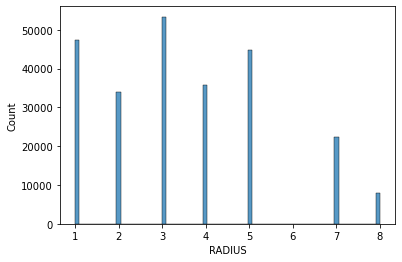

3.5141653609002668
3.0


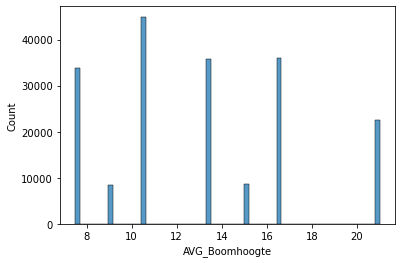

13.04295852389213
13.5


In [65]:
for var in ['RADIUS', 'AVG_Boomhoogte']:
    sns.histplot(data=bomen, x=var)
    plt.show()

    print(np.mean(bomen[var].dropna()))
    print(np.median(bomen[var].dropna()))

# Create Amstrees xy matrix functions

In [66]:
# borrowed from rijksdriehoek 0.0.1 library

X0      = 155000
Y0      = 463000
PHI0    = 52.15517440
LAM0    = 5.38720621

@nb.njit()
def wgs_to_rd(phi, lam):
    """
    Convert WGS84 cooridnates into rijksdriehoekcoordinates. Input parameters: phi (float), lambda (float). 
    """

    pqr = [(0, 1, 190094.945),
           (1, 1, -11832.228),
           (2, 1, -114.221),
           (0, 3, -32.391),
           (1, 0, -0.705),
           (3, 1, -2.34),
           (1, 3, -0.608),
           (0, 2, -0.008),
           (2, 3, 0.148)]
    
    pqs = [(1, 0, 309056.544),
           (0, 2, 3638.893),
           (2, 0, 73.077),
           (1, 2, -157.984),
           (3, 0, 59.788),
           (0, 1, 0.433),
           (2, 2, -6.439),
           (1, 1, -0.032),
           (0, 4, 0.092),
           (1, 4, -0.054)]

    dphi = 0.36 * ( phi - PHI0 )
    dlam = 0.36 * ( lam - LAM0 )

    X = X0
    Y = Y0

    for p, q, r in pqr:
        X += r * dphi**p * dlam**q 

    for p, q, s in pqs:
        Y += s * dphi**p * dlam**q

    return [X,Y]

coord_wgs = [[52.37422, 4.89801], # Amsterdam
            [51.92183, 4.47959], # Rotterdam
            [50.84660, 5.69006]] # Maastricht

for phi, lam in coord_wgs:
    print (wgs_to_rd(phi, lam))

[121686.82455220567, 487483.97188708844]
[92564.71163681961, 437428.2590417518]
[176330.8235243355, 317461.68549178494]


In [67]:
def tree_df_to_xy(trees_df):
    xy = np.zeros((len(trees_df), 2), dtype = np.float32)
    for index, tree in trees_df.iterrows():
        PHI = tree['LAT']
        LAM = tree['LNG']
        xy[index, 0:2] = wgs_to_rd(PHI, LAM)
    return xy

# calculate sensitivity functions

In [68]:
@numba.njit(parallel=False)
def assign_trees(d_matrix, max_range):
    
    n_predicted_trees = d_matrix.shape[0]

    pred_trees_true_indices = np.full(n_predicted_trees, np.NaN, dtype=np.float64)
    pred_trees_distances = np.full(n_predicted_trees, np.NaN, dtype=np.float64)

    # loop over predicted trees to find nearest true tree index and distance
    for i in nb.prange(n_predicted_trees):
        nearest_tree_index = np.argmin(d_matrix[i])
        dist = d_matrix[i, nearest_tree_index]
        # if true nearest tree is closer than predifined distance, set to correct prediction
        if dist < max_range:
            pred_trees_true_indices[i] = nearest_tree_index
            pred_trees_distances[i] = dist
            # set arbitrair large distance for true tree to prevent re-assignment
            d_matrix[:, nearest_tree_index] = np.full(n_predicted_trees, 1000000.0)

    return pred_trees_true_indices, pred_trees_distances

def pred_sensitivity(true, pred, max_range, x_min, x_max, y_min, y_max):
    
    n_row = 3
    n_col = 3

    # construct intervals
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_step = x_range / n_row
    y_step = y_range / n_col
    row_x_intervals = [x_min]
    col_y_intervals = [y_min]
    for i in range(n_row):
        row_x_intervals.append((i+1)*x_step + x_min)
    for i in range(n_col):
        col_y_intervals.append((i+1)*y_step + y_min)
    row_x_intervals = np.array(row_x_intervals, dtype=np.float64)
    col_y_intervals = np.array(col_y_intervals, dtype=np.float64)

    tp, n_trees = 0, 0
    
    for xi_ind in tqdm(range(len(row_x_intervals) - 1)):
        for yi_ind in range(len(col_y_intervals) - 1):
            true_temp = true[(true[:,0] > row_x_intervals[xi_ind]) & (true[:,0] < row_x_intervals[xi_ind+1]) &
                             (true[:,1] > col_y_intervals[yi_ind]) & (true[:,1] < col_y_intervals[yi_ind+1])]
            pred_temp = pred[(pred[:,0] > row_x_intervals[xi_ind]) & (pred[:,0] < row_x_intervals[xi_ind+1]) &
                             (pred[:,1] > col_y_intervals[yi_ind]) & (pred[:,1] < col_y_intervals[yi_ind+1])]

            d_matrix = distance_matrix(pred_temp, true_temp)

            pred_trees_true_indices, pred_trees_distances = assign_trees(d_matrix, max_range)
            tp += len(np.unique(pred_trees_true_indices, return_counts=False))
            n_trees += len(true_temp)

    return tp, n_trees


# load pred tree data

In [6]:
PredTrees = []
for filename in glob.glob("municipality_trees/treecount_accuracy/out*.txt"):
    df = pd.read_csv(filename, index_col=None, header=None, delimiter = ',')
    PredTrees.append(df)
PredTrees = pd.concat(PredTrees, axis=0, ignore_index=True)
PredTrees = PredTrees[[0, 1]].to_numpy(dtype=np.float32)

def trees_between_xy_minmax(xy_arr, x_min, x_max, y_min, y_max):
    xy_arr = xy_arr[(xy_arr[:,0] > x_min) & (xy_arr[:,0] < x_max) &
                    (xy_arr[:,1] > y_min) & (xy_arr[:,1] < y_max)]
    return xy_arr

In [71]:
# get min max coordinate values from pred_trees to select AmsTrees from
pred_x_min = np.min(PredTrees[:,0])
pred_x_max = np.max(PredTrees[:,0])
pred_y_min = np.min(PredTrees[:,1])
pred_y_max = np.max(PredTrees[:,1])
print("pred trees x min max       :", pred_x_min, pred_x_max, pred_x_max-pred_x_min)
print("pred trees y min max       :", pred_y_min, pred_y_max, pred_y_max-pred_y_min)
AmsTrees = tree_df_to_xy(bomen)
print("All Amstrees               :", len(AmsTrees))
AmsTrees = trees_between_xy_minmax(AmsTrees, pred_x_min, pred_x_max, pred_y_min, pred_y_max)
print("Amstrees in pred tree area :", len(AmsTrees))

pred trees x min max       : 120000.09 124999.99 4999.8984
pred trees y min max       : 481250.0 487499.84 6249.8438
All Amstrees               : 245705
Amstrees in pred tree area : 63625


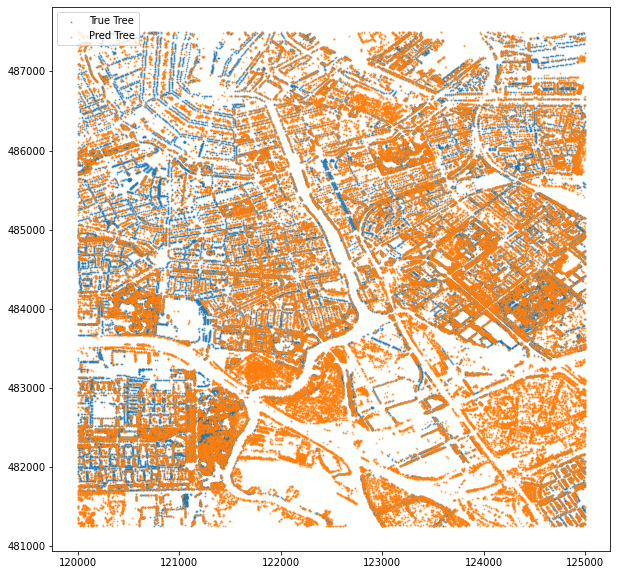

In [23]:
# %matplotlib widget
plt.scatter(AmsTrees[:, 0], AmsTrees[:, 1], s=1, label="True Tree", alpha=0.5)#, c='r')
plt.scatter(PredTrees[:, 0], PredTrees[:, 1], s=1, label="Pred Tree", alpha=0.5)#, c='g')
plt.legend()
plt.gcf().set_size_inches(10, 10)
plt.show()

In [25]:
tp, n_trees = pred_sensitivity(AmsTrees, PredTrees, max_range=4, x_min=pred_x_min, x_max=pred_x_max, y_min=pred_y_min, y_max=pred_y_max)
print("sensitivity =",tp / n_trees)

  0%|          | 0/3 [00:00<?, ?it/s]

sensitivity =  0.4579489194499018


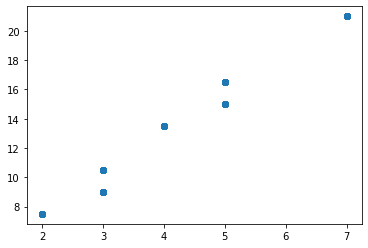

In [59]:
plt.scatter(bomen['RADIUS'], bomen['AVG_Boomhoogte'])
plt.show()

In [62]:
maxr = 4

trees_tmp = bomen[(bomen.RADIUS < 4)].reset_index()
trees_tmp = tree_df_to_xy(trees_tmp)
trees_tmp = trees_between_xy_minmax(trees_tmp, pred_x_min, pred_x_max, pred_y_min, pred_y_max)
tp, n_trees = pred_sensitivity(trees_tmp, PredTrees, max_range=maxr, x_min=pred_x_min, x_max=pred_x_max, y_min=pred_y_min, y_max=pred_y_max)
print("sensitivity radius <4  :", round(tp / n_trees, 2))

trees_tmp = bomen[(bomen.RADIUS >= 4)].reset_index()
trees_tmp = tree_df_to_xy(trees_tmp)
trees_tmp = trees_between_xy_minmax(trees_tmp, pred_x_min, pred_x_max, pred_y_min, pred_y_max)
tp, n_trees = pred_sensitivity(trees_tmp, PredTrees, max_range=maxr, x_min=pred_x_min, x_max=pred_x_max, y_min=pred_y_min, y_max=pred_y_max)
print("sensitivity radius >= 4:", round(tp / n_trees, 2))


  0%|          | 0/3 [00:00<?, ?it/s]

sensitivity radius <4  : 0.34


  0%|          | 0/3 [00:00<?, ?it/s]

sensitivity radius >= 4: 0.66
